In [43]:
%matplotlib widget
from struct import unpack
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

In [6]:
fileMagic = 0xCAFEBABE

In [7]:
f = open("sample.hof", "rb")
dataRaw = f.read()
f.close()
# check magic
if unpack(">I", dataRaw[0:4])[0] != fileMagic:
    raise ValueError("Invalid file format")
print("Valid file format")

Valid file format


In [8]:
typeEnum = {
    'block' : 0,
    'i32': 1,
    'float': 3,
    'double': 4,
    'string': 6
}
offset = 0

In [9]:
def loadStringFromBlock(blockData, start = 0, offset = 0):
    metaMagic = unpack(">B", blockData[start:start+1])[0]
    stringMagic = unpack(">B", blockData[start+1:start+2])[0]
    stringLength = unpack(">h", blockData[start+2:start+4])[0]
    stringData = blockData[start+4:start+4+stringLength]
    if stringMagic != typeEnum['string']:
        print(blockData[start:start+10])
        raise ValueError(f"Invalid type, expected string ({typeEnum['string']}), got {stringMagic}")
    return {
        "metaMagic": metaMagic,
        "magic": stringMagic,
        "type" : "string",
        "start": hex(offset + start),
        "stop": hex(offset + start + 4 + stringLength - 1),
        "length": stringLength,
        "value": stringData.decode('utf-8'),
        "offsetEnd": offset + 4 + stringLength,
        "fullLength": 4 + stringLength
    }


In [10]:
# magic: 1 byte
# type: 1 byte (should be 2 for block)
# longBlock: 1 (value = 2) + 8 bytes long (big endian)
# content: longBlock bytes
# padding: 1 byte (value is zero)
blockHeaderOffset = 11
def loadBlockFromBlock(blockData, start = 0, offset = 0):
    (metaMagic, blockType, typeLong, blockLength) = unpack(">BBBq", blockData[start:start+blockHeaderOffset])
    blockData = blockData[start+blockHeaderOffset:start+blockHeaderOffset+blockLength]
    if typeLong != 2:
        raise ValueError("Invalid long type")
    return {
        "metaMagic": metaMagic,
        "magic": blockType,
        "type": "block",
        "length": blockLength,
        "data": blockData,
        "start": hex(offset),
        "stop": hex(offset + blockHeaderOffset + blockLength + 1),     # at the end of block, there is a padding byte (value = 0)
        "offsetEnd": offset + blockHeaderOffset + blockLength + 1,
        "fullLength": blockHeaderOffset + blockLength + 1
    }

In [11]:
# magic: 1 byte
# type: 1 byte (should be 3 for i32)
# value: 4 bytes (big endian)
i32BlockLen = 6
def loadI32(blockData, start, offset):
    i32Magic = unpack(">B", blockData[start:start+1])[0]
    i32Type = unpack(">B", blockData[start+1:start+2])[0]
    if i32Type != 1:
        raise ValueError(f"Invalid i32 type {3}, got {i32Type}")
    i32Value = unpack(">i", blockData[start+2:start+6])[0]
    return {
        "magic": i32Type,
        "type": "i32",
        "value": i32Value,
        "start": hex(offset + start),
        "stop": hex(offset + start + i32BlockLen),
        "offsetEnd": offset + i32BlockLen,
        "fullLength": i32BlockLen
    }

In [12]:
def loadFloat(blockData, start, offset):
    floatMagic = unpack(">B", blockData[start:start+1])[0]
    floatType = unpack(">B", blockData[start+1:start+2])[0]
    if floatType != 3:
        raise ValueError(f"Invalid float type {3}, got {floatType}")
    floatValue = unpack(">f", blockData[start+2:start+6])[0]
    return {
        "magic": floatType,
        "type": "float",
        "value": floatValue,
        "start": hex(offset + start),
        "stop": hex(offset + start + 6),
        "offsetEnd": offset + 6,
        "fullLength": 6
    }

In [13]:
def loadDouble(blockData, start, offset):
    doubleMagic = unpack(">B", blockData[start:start+1])[0]
    doubleType = unpack(">B", blockData[start+1:start+2])[0]
    if doubleType != 4:
        raise ValueError(f"Invalid double type {4}, got {doubleType}")
    doubleValue = unpack(">d", blockData[start+2:start+10])[0]
    return {
        "magic": doubleType,
        "type": "double",
        "value": doubleValue,
        "start": hex(offset + start),
        "stop": hex(offset + start + 10),
        "offsetEnd": start + 10,
        "fullLength": 10
    }

In [14]:
def loadBoolean(blockData, start, offset):
    boolMagic = unpack(">B", blockData[start:start+1])[0]
    boolType = unpack(">B", blockData[start+1:start+2])[0]
    if boolType != 5:
        raise ValueError(f"Invalid boolean type {5}, got {boolType}")
    boolValue = unpack(">B", blockData[start+2:start+3])[0]
    return {
        "magic": boolType,
        "type": "boolean",
        "value": boolValue != 0,
        "start": hex(offset + start),
        "stop": hex(offset + start + 3),
        "offsetEnd": offset + 3,
        "fullLength": 3
    }

In [ ]:
def parseStruct(blockData, category):
    res = []
    index = 0
    while index < len(blockData) - 2:
        idx = unpack(">B", blockData[index:index+1])[0]
        if idx not in category:
            print("Unknown struct category", idx)
            break
        itemType = category[idx]
        remainsType = unpack(">B", blockData[index+1:index+2])[0]
        if remainsType == 1:
            item = loadI32(blockData[index:], 0, index)
        elif remainsType == 3:
            item = loadFloat(blockData[index:], 0, index)
        elif remainsType == 4:
            item = loadDouble(blockData[index:], 0, index)
        elif remainsType == 5:
            item = loadBoolean(blockData[index:], 0, index)
        elif remainsType == 6:
            item = loadStringFromBlock(blockData[index:], 0, index)
        else:
            print("Unknown item type", remainsType)
            break
        res.append({
            "category": itemType,
            **item
        })
        index += item['fullLength']

    result = {}
    for category, name in category.items():
        found = False
        for item in res:
            if item['category'] == name:
                found = True
                break
        if not found:
            continue
        result[name] = item['value']
    return result

# type hint: list<xxxx>
def loadStructList(blockData, blockType, category, start, offset):
    blockData = loadBlockFromBlock(blockData, start, offset)
    if blockData is None:
        return None
    index = 0
    res = []
    while index + blockHeaderOffset < blockData['length']:
        innerBlock = loadBlockFromBlock(blockData['data'], index, offset + blockHeaderOffset + index)
        if innerBlock is None:
            break
        content = parseStruct(innerBlock['data'], category)
        if content is None:
            break
        res.append({
            "metaMagic": innerBlock['metaMagic'],
            "magic": innerBlock['type'],
            "type": blockType + 'Item',
            "content": content,
            "start": innerBlock['start'],
            "stop": innerBlock['stop'],
            "length": innerBlock['length'],
            "fullLength": innerBlock['fullLength']
        })
        index += innerBlock['fullLength']
    blockData['content'] = res
    blockData['type'] = blockType
    del blockData['data']
    return blockData

# type hint: {
#   metaInfo: xxx,
#   content: list<xxx>
# }
def loadStructWithHeaderAndListContent(blockData, headLoaders, blockType, category, start, offset):
    structBlock = loadBlockFromBlock(blockData, start, offset)
    if structBlock is None:
        return None
    headers = {}
    index = 0
    for field, loader in headLoaders.items():
        item = loader(structBlock['data'], index, offset + blockHeaderOffset + index)
        headers[field] = item['value']
        index += item['fullLength']
    contentList = []
    while index < len(structBlock['data']) - 2:
        contentItemBlock = loadBlockFromBlock(structBlock['data'], index, offset + blockHeaderOffset + index)
        data = parseStruct(contentItemBlock['data'], category)
        contentList.append(data)
        index += contentItemBlock['fullLength']
    structBlock['headers'] = headers
    structBlock['content'] = contentList
    del structBlock['data']
    structBlock['type'] = blockType
    return structBlock

# type hint: list<{
#   metaInfo: xxx,
#   content: list<xxx>
# }>
def loadStructListOfListWithHeader(blockData, headLoaders, blockType, category, offset):
    listBlocks = loadBlockFromBlock(blockData, 0, offset)
    if listBlocks is None:
        return None
    index = 0
    blockLength = len(listBlocks['data'])
    offset += blockHeaderOffset
    res = []
    while index < blockLength - 2:
        innerStructBlock = loadBlockFromBlock(listBlocks['data'], index, offset + index)
        if innerStructBlock is None:
            break
        headers = {}
        innerIndex = 0
        for field, loader in headLoaders.items():
            item = loader(innerStructBlock['data'], innerIndex, offset + blockHeaderOffset + index + innerIndex)
            headers[field] = item['value']
            innerIndex += item['fullLength']
        contentList = []
        while innerIndex < len(innerStructBlock['data']) - 2:
            contentItemBlock = loadBlockFromBlock(innerStructBlock['data'], innerIndex, offset + blockHeaderOffset + index + innerIndex)
            data = parseStruct(contentItemBlock['data'], category)
            contentList.append(data)
            innerIndex += contentItemBlock['fullLength']
        innerStructBlock['headers'] = headers
        innerStructBlock['content'] = contentList
        del innerStructBlock['data']
        innerStructBlock['type'] = blockType + 'Item'
        res.append(innerStructBlock)
        offset += innerStructBlock['fullLength']
        index += innerStructBlock['fullLength']
    del listBlocks['data']
    listBlocks['content'] = res
    listBlocks['type'] = blockType
    return listBlocks


In [16]:
nodeDefCategory = {
    1: 'nodeId',
    2: 'label',
    3: 'category',
    4: 'type',
    5: 'elevation',
    6: 'x',
    7: 'y',
    8: 'branchPipes',
    9: 'vaporPressure',
    10: 'maxVolume',
    11: 'volumeType',
    12: 'code'

}

In [17]:
pipeDefCategory = {
    1: 'pipeId',
    2: 'label',
    3: 'lowNode',
    4: 'highNode',
    5: 'length',
    6: 'diameter',
    7: 'hwCoefficient',
    8: 'smoothCoefficient',
    9: 'waveSpeed',
    10: 'subDivs',
    11: 'velocity',
    12: 'checkValve',
    13: 'valveSpeedAdjustment',
    14: 'lengthAdjustment',
}

In [18]:
endPointResultCategory = {
    1: 'pipeId',
    2: 'nodeId',
    3: 'initialHead',
    4: 'maxPressure',
    5: 'minPressure',
    6: 'upsurgeRatio'
}

In [19]:
pathDataCategory = {
    1: 'pipeId',
    2: 'nodeOrPercentDistanceInt',
    10: 'nodeOrPercentDistanceFloat',
    3: 'distance',
    4: 'elevation',
    5: 'initialHead',
    6: 'maxHead',
    7: 'minHead',
    8: 'maxVolume',
    9: 'vapourPressure',
}

def loadPathData(blockData, offset):
    headLoaders = {
        'label': loadStringFromBlock
    }
    return loadStructListOfListWithHeader(blockData, headLoaders, "pathSegment", pathDataCategory, offset)

In [20]:
historyDataCategory = {
    1: 'time',
    2: 'flow',
    3: 'head',
    4: 'volume'
}
def loadHistoryData(blockData, offset):
    headLoaders = {
        'pipeId': loadI32,
        'nodeId': loadI32
    }
    return loadStructListOfListWithHeader(blockData, headLoaders, "historyDataItem", historyDataCategory, offset)

In [21]:
pointDataCategory = {
    1: 'pipeId',
    2: 'nodeOrPercentDistanceInt',
    0x17: 'nodeOrPercentDistanceFloat',
    0xf: 'distance',
    3: 'elevation',
    0x10: 'initialHead',
    4: 'maxHead',
    5: 'minHead',
    6: 'maxVolume',
    7: 'volumeType',
    8: 'currentVolume',
    9: 'collapse',
    10: 'vapourPressure',
    11: 'x',
    12: 'y',
    13: 'maxFlow',
    14: 'minFlow',
    0x11: 'maxVelocity',
    0x12: 'minVelocity',
    0x13: 'maxPressure',
    0x14: 'minPressure',
    0x15: 'numOfPoints',
    0x16: 'initialPressure',
}
def loadPointData(blockData, offset):
    headLoaders = {
        'numOfPipes': loadI32
    }
    return loadStructWithHeaderAndListContent(blockData, headLoaders, "pointDataItem", pointDataCategory, 0, offset)

In [22]:
animateDataCategory = {
    1: 'pipeId',
    2: 'nodeInt',
    6: 'nodeFloat',
    3: 'flow',
    4: 'head',
    5: 'volume',
}
def loadAnimateData(blockData, offset):
    headLoaders = {
        'time': loadFloat
    }
    return loadStructListOfListWithHeader(blockData, headLoaders, "animateData", animateDataCategory, offset)

In [23]:
unitDataCategory = {
    1: 'hammerUnitDimension',
    2: 'hammerUnitIndex',
    3: 'precision',
    4: 'useScientificNotation'
}

In [24]:
metaMagicEnum = {
    'nodeDef': 2,
    'pipeDef': 3,
    'endPointResult': 4,
    'pathSegment': 5,
    'historyData': 6,
    'pointData': 7,
    'forceHistoryData': 8,
    'forceMaxHistoriesData': 9,
    'animateData': 10,
    'unitData': 0x64
}

In [37]:
def loadAny(blockData, offset = 0, maxSegments = 0):
    index = 0
    blockLength = len(blockData)
    res = []
    iter = 0
    while index + blockHeaderOffset < blockLength:
        if maxSegments > 0 and iter >= maxSegments:
            break
        iter += 1
        metaMagic = unpack(">B", blockData[index:index+1])[0]
        contentMagic = unpack(">B", blockData[index+1:index+2])[0]
        item = None
        if contentMagic == 6:
            item = loadStringFromBlock(blockData[index:], 0, offset)
        elif metaMagic == 2:
            item = loadStructList(blockData[index:], "nodeDef", nodeDefCategory, 0, offset)
        elif metaMagic == 3:
            item = loadStructList(blockData[index:], "pipeDef", pipeDefCategory, 0, offset)
        elif metaMagic == 4:
            item = loadStructList(blockData[index:], "endPointResult", endPointResultCategory, 0, offset)
        elif metaMagic == 5:
            item = loadPathData(blockData[index:], offset)
        elif metaMagic == 6:
            item = loadHistoryData(blockData[index:], offset)
        elif metaMagic == 7:
            item = loadPointData(blockData[index:], offset)
        elif metaMagic == 9:    # forceHistory (skip)
            item = loadBlockFromBlock(blockData[index:], 0, offset)
        elif metaMagic == 0x0A: # ForceMaxHistoriesData(skip)
            item = loadBlockFromBlock(blockData[index:], 0, offset)
        elif metaMagic == 8:
            item = loadAnimateData(blockData[index:], offset)
        elif metaMagic == 0x64:
            item = loadStructList(blockData[index:], "unitData", unitDataCategory, 0, offset)
        elif contentMagic == 0:
            item = loadBlockFromBlock(blockData[index:], 0, offset)
            contents = loadAny(item['data'], offset=offset + 11)
            item['content'] = contents
            del item['data']
        elif contentMagic == 1:
            item = loadI32(blockData[index:], 0, offset)
            if item is None:
                break
        else:
            print('Unknown content type', hex(contentMagic))
            break
        
        if item is None:
            break
        res.append(item)
        index += item['fullLength']
        offset += item['fullLength']

    return res

# Parse

In [26]:
basicOffset = 0x0f
dataContent = dataRaw[basicOffset:]

In [38]:
allSegments = loadAny(dataContent, 0xf, 12)
def getSegment(segmentType):
    for segment in allSegments:
        if 'type' in segment and segment['type'] == segmentType:
            return segment
    raise ValueError(f"Segment {segmentType} not found")

In [28]:
def getPipeById(pipeId):
    pipeSegment = getSegment('pipeDef')
    if pipeSegment is None:
        raise ValueError("No pipe segment found")
    pipeDbLabel = f"{pipeId}:"
    for pipe in pipeSegment['content']:
        if 'content' in pipe and 'label' in pipe['content'] and type(pipe['content']['label']) == str:
            if pipe['content']['label'].startswith(pipeDbLabel):
                return pipe['content']
    raise ValueError(f"No pipe found with id {pipeId}") 

def getNodeById(nodeId):
    nodeSegment = getSegment('nodeDef')
    if nodeSegment is None:
        raise ValueError("No node segment found")
    nodeDbLabel = f"{nodeId}:"
    for node in nodeSegment['content']:
        if 'content' in node and 'label' in node['content'] and type(node['content']['label']) == str:
            if node['content']['label'].startswith(nodeDbLabel):
                return node['content']
    raise ValueError(f"No node found with id {nodeId}")

def getNodeByDbId(dbId):
    nodeSegment = getSegment('nodeDef')
    if nodeSegment is None:
        raise ValueError("No node segment found")
    for node in nodeSegment['content']:
        if 'content' in node and 'nodeId' in node['content'] and type(node['content']['nodeId']) == int:
            if node['content']['nodeId'] == dbId:
                return node['content']
    raise ValueError(f"No node found with dbId {dbId}")

def getPathByLabel(pathLabel):
    pathSegment = getSegment('pathSegment')
    if pathSegment is None:
        raise ValueError("No path segment found")
    for path in pathSegment['content']:
        if 'headers' in path and 'label' in path['headers'] and type(path['headers']['label']) == str:
            if path['headers']['label'].endswith(f":{pathLabel}"):
                return path
    raise ValueError(f"No path found with id {pathLabel}")

## Plotting

### Animate Data Visualization

In [39]:
animateList = []
animateData = getSegment('animateData')
for item in animateData['content']:
    time = item['headers']['time']
    for record in item['content']:
        animateList.append({
            "time": time,
            "locId": f"{int(record['pipeId'])}_{int(record['nodeInt'])}_{record['nodeFloat']:.1f}",
            **record
        })
animateDf = pd.DataFrame(animateList)
# animateDf.to_csv("animate.csv", index=False)


In [40]:
def loadAnimateForPath(pathLabel, animateDf, target):
    path = getPathByLabel(pathLabel)
    dfClone = animateDf.copy()
    times = dfClone['time'].unique()
    times.sort()
    maxY = None
    minY = None
    for segment in path['content']:
        locId = f"{int(segment['pipeId'])}_{int(segment['nodeOrPercentDistanceInt'])}_{segment['nodeOrPercentDistanceFloat']:.1f}"
        items = dfClone[dfClone['locId'] == locId]
        for item in items.iloc:
            value = float(item[target])
            if maxY is None:
                maxY = value
                minY = value
                continue
            if value > maxY:
                maxY = value
            if value < minY:
                minY = value
    def getByTime(time):
        sliceByTime = pd.DataFrame(dfClone[dfClone['time'] == time])
        data = {}
        for loc in sliceByTime.iloc:
            data[loc['locId']] = loc
        series = []
        for segment in path['content']:
            locId = f"{int(segment['pipeId'])}_{int(segment['nodeOrPercentDistanceInt'])}_{segment['nodeOrPercentDistanceFloat']:.1f}"
            item = data.get(locId, None)
            if item is not None:
                series.append(item[target])
        return series
    return (times, getByTime, minY, maxY)

interactive(children=(IntSlider(value=0, description='time', max=159), Output()), _dom_classes=('widget-intera…

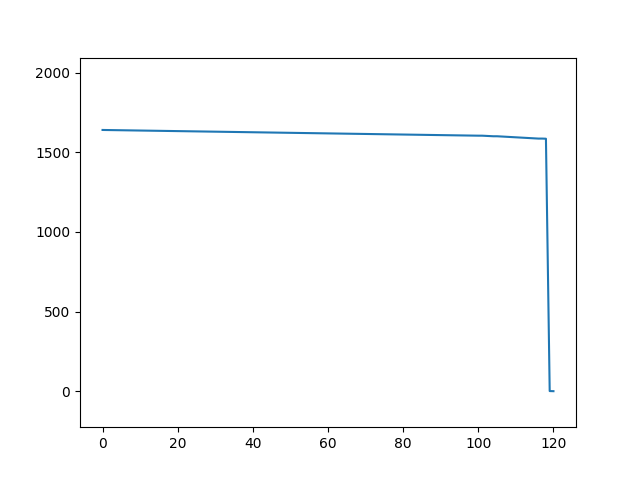

In [42]:
(times, resFn, minY, maxY) = loadAnimateForPath('middle', animateDf, 'head')
fig = plt.figure()
line, = plt.plot(resFn(0.0))
diff = maxY - minY
plt.ylim(minY - diff * 0.1, maxY + diff * 0.1)
def updateTime(time = 0):
    time = times[time]
    line.set_ydata(resFn(time))
    line.set_xdata(range(len(line.get_ydata())))
    fig.canvas.draw_idle()
interact(updateTime, time = (0, len(times) - 1, 1))
plt.show()

### Node Time-Series Data

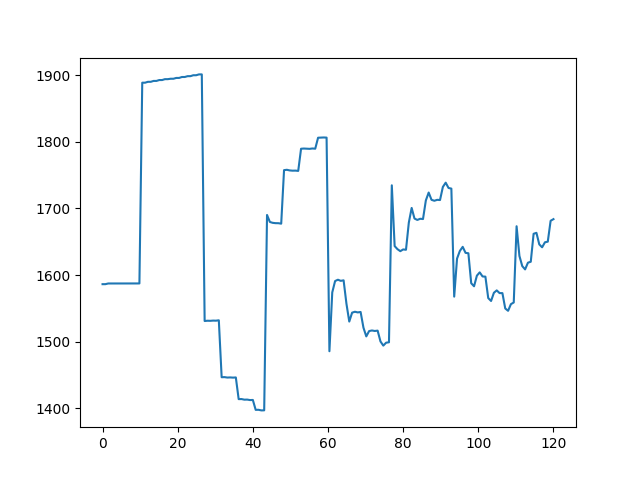

In [32]:
fig = plt.figure()
pipe = getPipeById(92)
node = getNodeById(91)
sliceByNodeInt = pd.DataFrame(animateDf[(animateDf['nodeInt'] == node['nodeId']) & (animateDf['pipeId'] == pipe['pipeId'])])
sliceByNodeInt.sort_values(by=['time'], inplace=True)
plt.plot(sliceByNodeInt['time'], sliceByNodeInt['head'])